# Master Process Only:

In [1]:
using Distributed
using LaTeXStrings
using KDTree
using CPUTime

Distributed.addprocs(4)

using PyPlot
plt = PyPlot

PyPlot

# Workers:

In [2]:
@everywhere begin 
    using Distributed
    using Distributions 
    using IntervalSets
    using ValueShapes
    using ArraysOfArrays
    using StatsBase 
    using LinearAlgebra
    using BATPar
    using BAT
    using JLD2
end

In [3]:
include("plotting recipes.jl")

corner_plots (generic function with 6 methods)

In [4]:
@everywhere begin
    
    JLD2.@load "MixtureModels/mixture-1.jld" means cov_m n_clusters
    model = MixtureModel(MvNormal[MvNormal(means[i,:], Matrix(Hermitian(cov_m[i,:,:])) ) for i in 1:n_clusters])

    N = 6
    min_v = -100.
    max_v = 100.
    lgV = N*log(max_v-min_v); 
    likelihood = let model=model ;begin params -> LogDVal(logpdf(model, params.a)) end end
end

In [ ]:
@everywhere begin 
    g(x;) = prod(pdf.(Normal(), x))
    N = 2
    min_v = -10.
    max_v = 10.
    lgV = N*log(max_v-min_v); 
    likelihood = params -> LogDVal((log(g(params.a))))
end

In [ ]:
@everywhere begin

    true_param =(μ1=4, μ2=-4, σ=0.13)

    function g(x::AbstractArray; true_param=true_param)
        tmp = 1
        for i in eachindex(x)
            if i > 2
                tmp *= pdf(Cauchy(true_param.μ1 + true_param.μ2, true_param.σ), x[i])
            else 
                tmp *= 0.5*pdf(Cauchy(true_param.μ1, true_param.σ), x[i]) + 0.5*pdf(Cauchy(true_param.μ2, true_param.σ), x[i])
            end
        end
        return tmp
    end

    function LogTrueIntegral(N; max = max_v, min=min_v,  true_param=true_param) 
        tmp = 0
        for i in 1:N
            if i > 2
                tmp += log(cdf(Cauchy(true_param.μ1 + true_param.μ2,true_param.σ), max_v) - cdf(Cauchy(true_param.μ1 + true_param.μ2,true_param.σ), min_v))
            else 
                tmp += log(cdf(Cauchy(true_param.μ1,true_param.σ), max_v) - cdf(Cauchy(true_param.μ1 ,true_param.σ), min_v))
            end
        end
        return tmp
    end

    N = 10
    min_v = -10.
    max_v = 10.
    lgV = N*log(max_v-min_v); 
    likelihood = params -> LogDVal((log(g(params.a))))
    
end
    

## Exploration samples: 

In [5]:
prior_exploration = NamedTupleDist(a = [[min_v .. max_v for i in 1:N]...],);
posterior_exploration = PosteriorDensity(likelihood, prior_exploration);

exp_samples = 50
exp_chains = 30

exploration_samples = bat_sample(posterior_exploration, (exp_samples, exp_chains), MetropolisHastings(),).result

data_kdtree = Data(collect(flatview(unshaped.(exploration_samples.v))), exploration_samples.weight, exploration_samples.logd);

┌ Info: Trying to generate 30 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 30 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 30 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 30 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 30 chains, 2 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 30 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 4 finished, 30 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tu

# Space Partitioning

In [6]:
n_partitions = 10
dims_partition = collect(1:N)

KDTree.evaluate_total_cost(data::Data) = KDTree.cost_f_1(data)

partition_tree, _ = DefineKDTree(data_kdtree, dims_partition, n_partitions)

extend_tree_bounds!(partition_tree, repeat([min_v], N), repeat([max_v], N))

┌ Info: KDTree: Increasing tree depth: depth = 1
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 2
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 3
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 4
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 5
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 6
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 7
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: depth = 8
└ @ KDTree /Users/vhafych/MPP-Server/gitrepos/KDTree/src/KDTree.jl:183
┌ Info: KDTree: Increasing tree depth: d

# Sampling of subspaces 

In [7]:
subspace_boundaries = extract_par_bounds(partition_tree)

@everywhere BATPar.make_named_prior(i) = BAT.NamedTupleDist( a =  [[i[j,1]..i[j,2] for j in 1:size(i)[1]]...])

nsamples_per_subspace = 10^5
nchains_per_subspace = 10

tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.35,
    β = 1.5,
    c = 1e-4..1e2
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = 25,
    max_ncycles = 40
)

AHMI_settings = BAT.HMISettings(BAT.cholesky_partial_whitening!, #cholesky_partial_whitening, cholesky_whitening
        20000, 2.0, 0.1, true, 30, true, 
    Dict("cov. weighted result" => BAT.hm_combineresults_covweighted!));

algorithm = MetropolisHastings();

@time samples_parallel = bat_sample_parallel(likelihood, subspace_boundaries, (nsamples_per_subspace, nchains_per_subspace), algorithm, tuning=tuning, burnin=burnin);

[ Info: BATPar: Sampling subspace 1:
[ Info: BATPar: Sampling subspace 3:
[ Info: BATPar: Sampling subspace 2:
[ Info: BATPar: Sampling subspace 4:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 t

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Determine Hyperrectangle Starting Samples


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Determine Hyperrectangle Starting Samples
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Determine Hyperrectangle Starting Samples
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Determine Tolerances for Hyperrectangle Creation


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Determine Hyperrectangle Starting Samples
[ Info: Create 104 Hyperrectangles using 8 thread(s)
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Create 82 Hyperrectangles using 8 thread(s)
[ Info: Create 91 Hyperrectangles using 8 thread(s)
[ Info: Create 143 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


[ Info: Updating 82 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Integrating 82 Hyperrectangles


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: BATPar: Sampling subspace 5:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 5 finished, 10 chains, 3 tuned, 0 converged.
[ Info: MCMC Tuning cycle 6 finished, 10 chains, 6 tuned, 0 converged.
[ Info: MCMC Tuning cycle 7 finished, 10 chains, 7 tuned, 0 converged.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


[ Info: MCMC Tuning cycle 8 finished, 10 chains, 9 tuned, 0 converged.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


[ Info: MCMC Tuning cycle 9 finished, 10 chains, 10 tuned, 0 converged.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


[ Info: MCMC Tuning cycle 10 finished, 10 chains, 9 tuned, 0 converged.
[ Info: Updating 104 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Integrating 104 Hyperrectangles
[ Info: MCMC Tuning cycle 11 finished, 10 chains, 6 tuned, 0 converged.
[ Info: Updating 91 Hyperrectangles using 8 thread(s)
[ Info: Updating 143 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Integrating 143 Hyperrectangles
[ Info: Integrating 91 Hyperrectangles
[ Info: MCMC Tuning cycle 12 finished, 10 chains, 7 tuned, 0 converged.
[ Info: MCMC Tuning cycle 13 finished, 10 chains, 8 tuned, 0 converged.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: MCMC Tuning cycle 14 finished, 10 chains, 8 tuned, 0 converged.
[ Info: MCMC Tuning cycle 15 finished, 10 chains, 7 tuned, 0 converged.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: MCMC Tuning cycle 16 finished, 10 chains, 8 tuned, 0 converged.
[ Info: MCMC Tuning cycle 17 finished, 10 chains, 9 tuned, 0 converged.
[ Info: MCMC Tuning cycle 18 finished, 10 chains, 7 tuned, 0 converged.
[ Info: MCMC Tuning cycle 19 finished, 10 chains, 9 tuned, 0 converged.
[ Info: MCMC Tuning cycle 20 finished, 10 chains, 7 tuned, 0 converged.
[ Info: MCMC Tuning cycle 21 finished, 10 chains, 8 tuned, 0 converged.
[ Info: MCMC Tuning cycle 22 finished, 10 chains, 9 tuned, 0 converged.
[ Info: MCMC Tuning cycle 23 finished, 10 chains, 7 tuned, 0 converged.
[ Info: BATPar: Sampling subspace 6:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: BATPar: Sampling subspace 7:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: BATPar: Sampling subspace 8:
[ Info: Trying to genera

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree
[ Info: Determine Hyperrectangle Starting Samples
[ Info: Apply Whitening Transformation to Data Set 2


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Create Space Partitioning Tree


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Determine Tolerances for Hyperrectangle Creation


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Determine Hyperrectangle Starting Samples


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Determine Hyperrectangle Starting Samples
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Create 64 Hyperrectangles using 8 thread(s)
[ Info: Create 145 Hyperrectangles using 8 thread(s)
[ Info: Create 142 Hyperrectangles using 8 thread(s)
[ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 499999	Parameters:	6
[ Info: Data Whitening.
[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


[ Info: Determine Hyperrectangle Starting Samples


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Updating 64 Hyperrectangles using 8 thread(s)
[ Info: Create 94 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[ Info: Integrating 64 Hyperrectangles


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: BATPar: Sampling subspace 9:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 4 finished, 10 chains, 1 tuned, 0 converged.
[ Info: MCMC Tuning cycle 5 finished, 10 chains, 4 tuned, 10 converged.


Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


[ Info: MCMC Tuning cycle 6 finished, 10 chains, 7 tuned, 10 converged.
[ Info: Updating 144 Hyperrectangles using 8 thread(s)
[ Info: Integrating 144 Hyperrectangles
[ Info: MCMC Tuning cycle 7 finished, 10 chains, 10 tuned, 10 converged.
[ Info: MCMC tuning of 10 chains successful after 7 cycle(s).


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: BATPar: Sampling subspace 10:
[ Info: Trying to generate 10 viable MCMC chain(s).
[ Info: Selected 10 MCMC chain(s).
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 5 finished, 10 chains, 8 tuned, 0 converged.
[ Info: MCMC Tuning cycle 6 finished, 10 chains, 10 tuned, 10 converged.
[ Info: MCMC tuning of 10 chains successful after 6 cycle(s).


Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


[ Info: Updating 142 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Integrating 142 Hyperrectangles
[ Info: Updating 94 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Integrating 94 Hyperrectangles


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: BATPar: Sampling subspace 11:
[ Info: Trying to generate 10 viable MCMC chain(s).


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


[ Info: Selected 10 MCMC chain(s).
[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: Begin tuning of 10 MCMC chain(s).
[ Info: MCMC Tuning cycle 1 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 2 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 3 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 4 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 5 finished, 10 chains, 0 tuned, 0 converged.
[ Info: MCMC Tuning cycle 6 finished, 10 chains, 2 tuned, 10 converged.
[ Info: MCMC Tuning cycle 7 finished, 10 chains, 7 tuned, 10 converged.
[ Info: MCMC Tuning cycle 8 finished, 10 chains, 10 tuned, 10 converged.
[ Info: MCMC tuning of 10 chains successful after 8 cycle(s).
[ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 499999	Parameters:	6
[ Info: Data Whitening.
[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[ Info: Determine Hyperrectangle Starting Samples
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 499999	Parameters:	6
[ Info: Data Whitening.
[ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	500000 / 499999	Parameters:	6
[ Info: Data Whitening.
[ Info: Create 69 Hyperrectangles using 8 thread(s)
[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree
[ Info: Apply Whitening Transformation to Data Set 2
[ Info: Create Space Partitioning Tree


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Determine Hyperrectangle Starting Samples


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Determine Hyperrectangle Starting Samples
[ Info: Determine Tolerances for Hyperrectangle Creation
[ Info: Create 79 Hyperrectangles using 8 thread(s)
[ Info: Create 73 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


[ Info: Updating 69 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Integrating 69 Hyperrectangles


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


[ Info: Estimating Uncertainty (cov. weighted result)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


[ Info: Updating 73 Hyperrectangles using 8 thread(s)
[ Info: Updating 79 Hyperrectangles using 8 thread(s)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Integrating 73 Hyperrectangles
[ Info: Integrating 79 Hyperrectangles


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[ Info: Estimating Uncertainty (cov. weighted result)
[ Info: Estimating Uncertainty (cov. weighted result)
┌ Info: BATPar: Sampling is finished. Combining samples:
└ @ BATPar /Users/vhafych/MPP-Server/gitrepos/BATPar.jl/src/BATPar.jl:58
┌ Info: BATPar: Ready!
└ @ BATPar /Users/vhafych/MPP-Server/gitrepos/BATPar.jl/src/BATPar.jl:75


555.274816 seconds (30.13 M allocations: 3.431 GiB, 1.31% gc time)


In [8]:
samples_temp = hcat(samples_parallel.samples...)
x = samples_temp[1,:]
y = samples_temp[2,:]
w_o = samples_parallel.weights_o
w_r =  samples_parallel.weights_r;

In [ ]:
@show exp(LogTrueIntegral(N))

In [9]:
[sum(samples_parallel.integrals), sqrt(sum((samples_parallel.uncertainty).^2))]

2-element Array{Float64,1}:
 1.5413720092854868
 0.022684892427927806

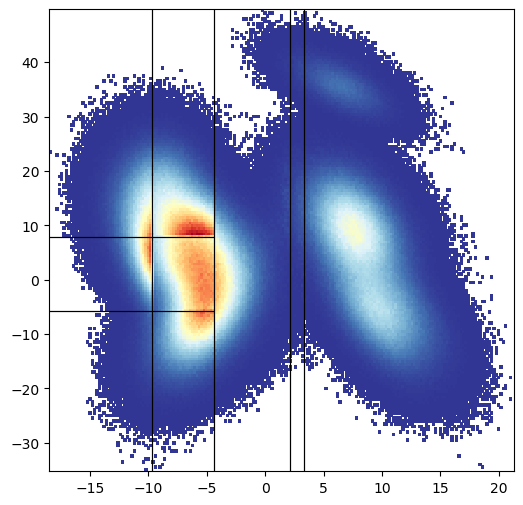

PyObject <matplotlib.patches.Rectangle object at 0x19601f050>

In [10]:
histogram_2D_r = fit(Histogram, (x,y), weights(w_o), nbins=200)
histogram_2D_r = normalize(histogram_2D_r, mode=:probability)

fig, ax = plt.subplots(1,1, figsize=(6, 6))

img = ax.pcolormesh(midpoints(histogram_2D_r.edges[1]), midpoints(histogram_2D_r.edges[2]), replace(histogram_2D_r.weights', 0=>NaN), cmap="RdYlBu_r") #terrain_r  vmin = -0.0001, vmax=maximum_v,
# fig.colorbar(img)

plot_tree(partition_tree, [1,2], ax, linewidth=0.8, color="black", alpha=1)

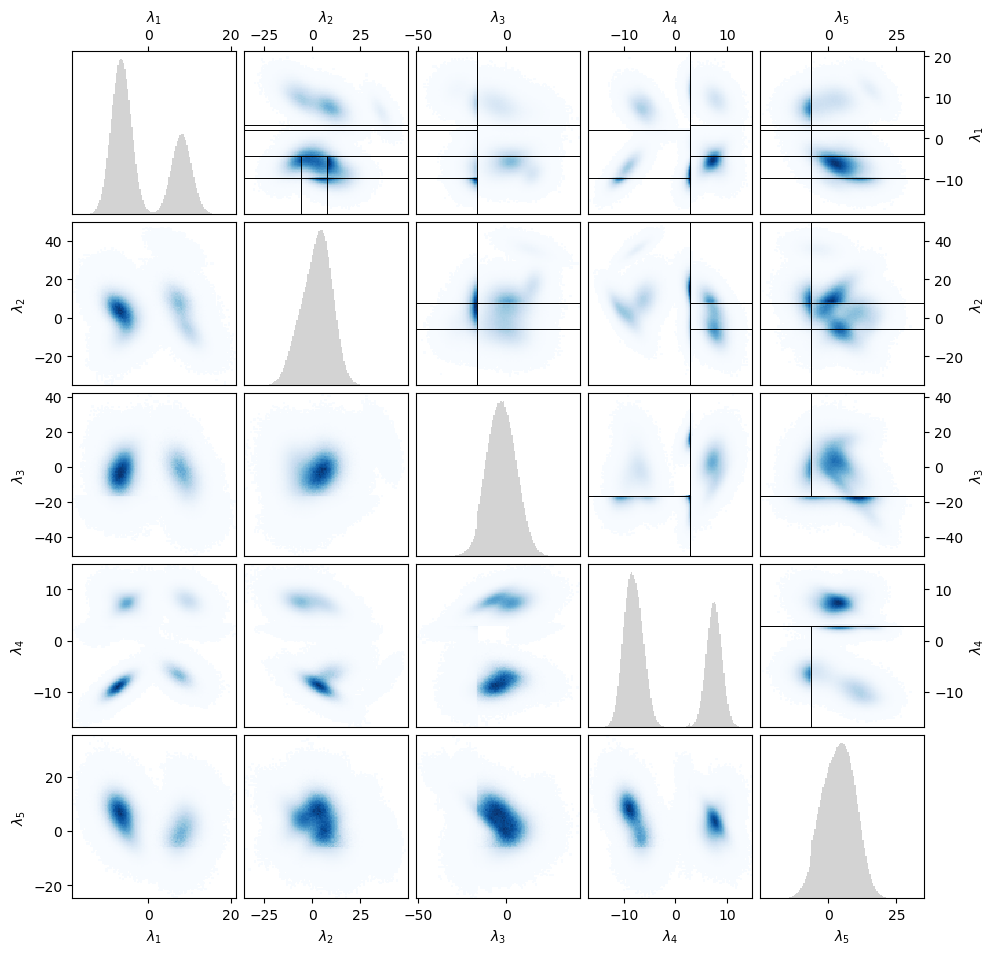

In [15]:
corner_plots(samples_temp, partition_tree, w_r, w_o, 
    [1,2,3,4,5], [L"\lambda_1", L"\lambda_2", L"\lambda_3", L"\lambda_4",  L"\lambda_5"], 
    N_bins=120, linewidth=0.6, color="black",
    save_plot=false,
    FILE_NAME = "../../MCMC_publication/fig-f-2-a.png",
    )

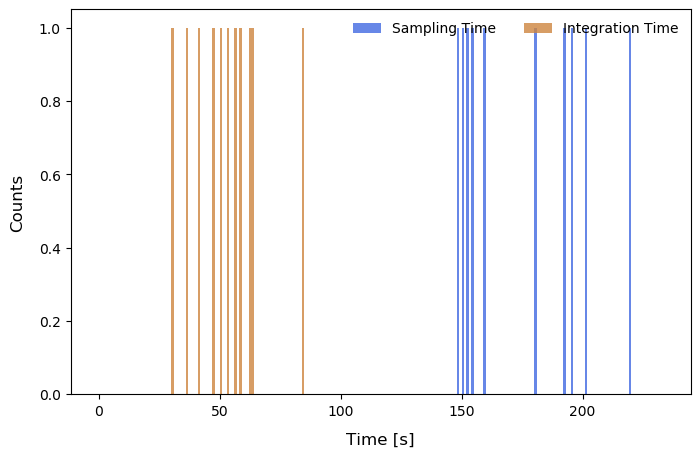

PyObject Text(25.000000000000004, 0.5, 'Counts')

In [12]:
plot_time_histogram(samples_parallel)

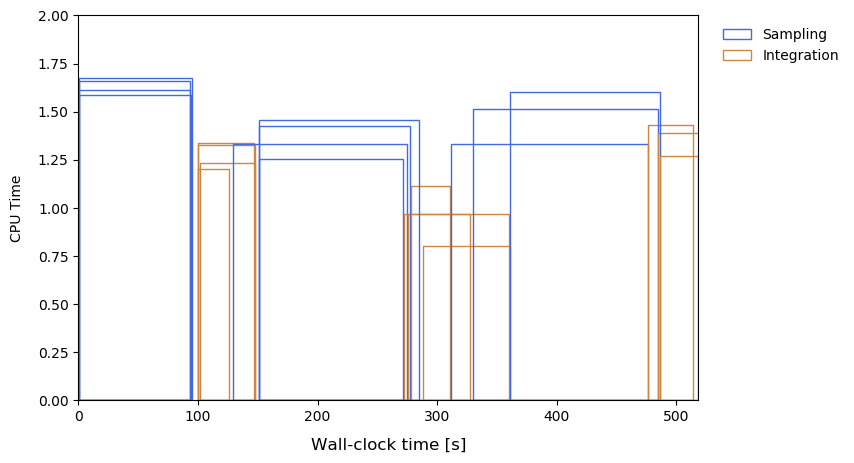

PyObject Text(0.5, 25.000000000000004, 'Wall-clock time [s]')

In [13]:
plot_overlapped_timeline(samples_parallel)

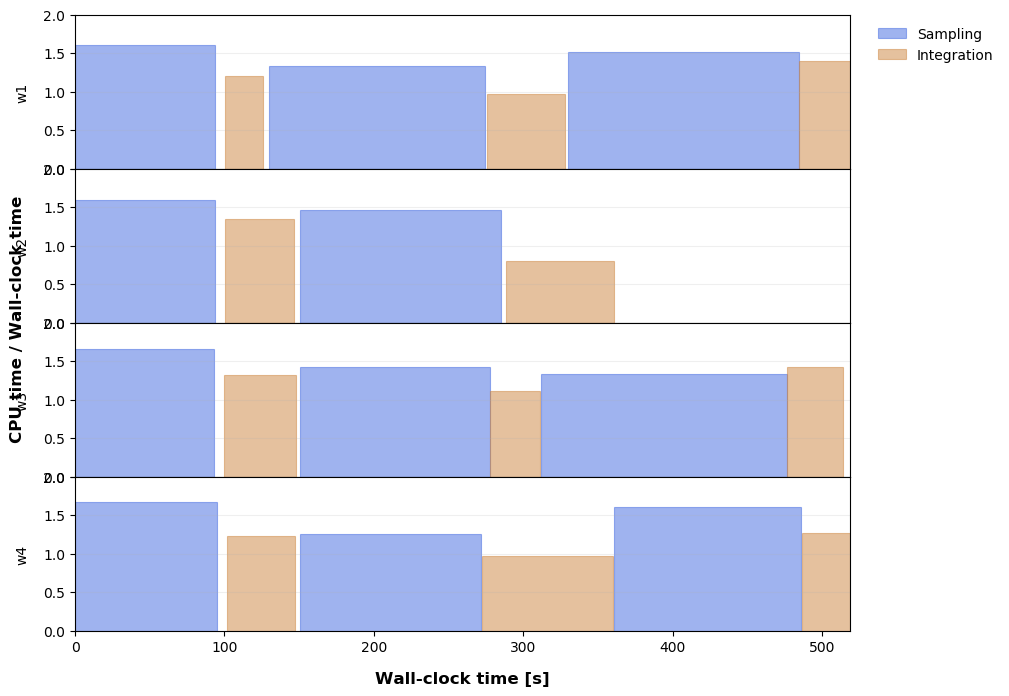

PyObject Text(0.5, 25.00000000000001, 'Wall-clock time [s]')

In [14]:
plot_separated_timeline(samples_parallel)

In [ ]:
# samples_ps = (samples = samples_parallel.samples,
#         weights_o = samples_parallel.weights_o,
#         weights_r = samples_parallel.weights_r,
#         log_lik = samples_parallel.log_lik,
#         space_ind = samples_parallel.space_ind,
#         uncertainty = samples_parallel.uncertainty,
#         integrals = samples_parallel.integrals,
#         time_mcmc = samples_parallel.time_mcmc,
#         time_integration = samples_parallel.time_integration,
#         proc_id = samples_parallel.proc_id,
#         n_threads = samples_parallel.n_threads,
#         timestamps = samples_parallel.timestamps
# );

# @save "Generated_Data/samples_ps-2.jld" samples_ps;

# # @load "samples_ps.jld" samples_ps